# Neural Net Language models

> Basic neuralnet-based language modeling 

In [24]:
#| default_exp models.lm

In [25]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
#| export
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader

import lightning as L
from lightning import Trainer, LightningModule
from lightning.pytorch.tuner.tuning import Tuner
from lightning.pytorch.callbacks import LearningRateFinder
from lightning.pytorch.loggers import CSVLogger



from matplotlib import pyplot as plt
import matplotlib
# plt.set_loglevel('INFO')
import pandas as pd
import numpy as np
from tqdm import tqdm
import pprint

from omegaconf import OmegaConf
from hydra.utils import instantiate

from typing import Dict, List, Tuple, Optional, Set
from dataclasses import dataclass, asdict

from nimrod.text.datasets import CharDataset, Vocab
from nimrod.utils import set_seed, get_device
from nimrod.models.core import Classifier, plot_classifier_metrics_from_csv
import nimrod

import logging

logger = logging.getLogger(__name__)
# N_EPOCHS for training debuggging
ITER_MAX = 1

In [27]:
set_seed(42)

Seed set to 42


In [28]:
# reading with pandas
df = pd.read_csv('../data/text/names.txt', header=None, names=['name'])
data = list(df.name)
print("names: ", data[:3])

names:  ['emma', 'olivia', 'ava']


## Data formatting
given last n tokens we predict token n+1

In [29]:
s = list("alexandra")
print(s)
bigram = [(x,y) for x, y in zip(s, s[1:])]
print(bigram)
trigram = [ (x,y,z) for x, y, z in zip(s, s[1:], s[2:])]
print(trigram)

['a', 'l', 'e', 'x', 'a', 'n', 'd', 'r', 'a']
[('a', 'l'), ('l', 'e'), ('e', 'x'), ('x', 'a'), ('a', 'n'), ('n', 'd'), ('d', 'r'), ('r', 'a')]
[('a', 'l', 'e'), ('l', 'e', 'x'), ('e', 'x', 'a'), ('x', 'a', 'n'), ('a', 'n', 'd'), ('n', 'd', 'r'), ('d', 'r', 'a')]


### Tiny shakespeare LM char dataset

In [30]:
# reading directly in plain python
lines = []
with open('../data/text/tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    for line in f.readlines():
        if line.strip():
            # only append non blank lines
            lines.append(line)

# add sentence tokens
# data = [['<bos>'] +list(line.strip()) + ['<eos>'] for line in lines]
# data = [list(line.strip()) for line in lines]
data = [list(line) for line in lines]
print("data: ", data[:3])

data:  [['F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n'], ['B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '\n'], ['A', 'l', 'l', ':', '\n']]


In [31]:

def make_dataset(
        words:List[str], # data is a list of sentences which are a list of words
        v:Vocab,# vocabulary class for mapping words to indices
        verbose:bool=False, # print debug info
        context_length=3 # number of words/tokens to use as context
        ):
    X = []
    y = []
    for word in words:
        s = list(word)
        if verbose:
            print('row: ', s)
        # init prefix with padding while len < context_length
        for i in range(context_length-1):
            sequence = v.stoi(s[:i+1])
            pad_len = context_length - len(sequence)
            pad = [v.stoi("<pad>")] * pad_len
            X.append(pad + sequence)
            y.append(v.stoi(s[i+1]))

            if verbose:
                print(["<pad>"]+ s[:i+1], s[i+1])

        # for length seq = context_length
        i = 0
        while i < (len(s) - context_length):
            X.append(v.stoi(s[i:context_length+i]))
            y.append(v.stoi(s[i+context_length]))
            if verbose:
                print(s[i:context_length+i], s[i+context_length])
            i += 1
    return torch.tensor(X),torch.tensor(y)


for each row in the dataset we expand all the combinations of ngrams

In [32]:
v = Vocab(data_path='../data/text/tiny_shakespeare.txt', specials=['<unk>','<pad>'])
print("vocabulary: ", v.vocabulary)
print("vocabulary size: ", len(v))


[00:01:41] INFO     [00:01:41]                                                                       ]8;id=288389;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=256787;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#66\66]8;;\

vocabulary:  ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '<pad>', '<unk>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocabulary size:  67


In [33]:
CONTEXT_LEN = 3
X, y = make_dataset(data[:80], v, verbose=True, context_length=CONTEXT_LEN)
print("X: ", X.shape, "y:", y.shape)

row:  ['F', 'i', 'r', 's', 't', ' ', 'C', 'i', 't', 'i', 'z', 'e', 'n', ':', '\n']
['<pad>', 'F'] i
['<pad>', 'F', 'i'] r
['F', 'i', 'r'] s
['i', 'r', 's'] t
['r', 's', 't']  
['s', 't', ' '] C
['t', ' ', 'C'] i
[' ', 'C', 'i'] t
['C', 'i', 't'] i
['i', 't', 'i'] z
['t', 'i', 'z'] e
['i', 'z', 'e'] n
['z', 'e', 'n'] :
['e', 'n', ':'] 

row:  ['B', 'e', 'f', 'o', 'r', 'e', ' ', 'w', 'e', ' ', 'p', 'r', 'o', 'c', 'e', 'e', 'd', ' ', 'a', 'n', 'y', ' ', 'f', 'u', 'r', 't', 'h', 'e', 'r', ',', ' ', 'h', 'e', 'a', 'r', ' ', 'm', 'e', ' ', 's', 'p', 'e', 'a', 'k', '.', '\n']
['<pad>', 'B'] e
['<pad>', 'B', 'e'] f
['B', 'e', 'f'] o
['e', 'f', 'o'] r
['f', 'o', 'r'] e
['o', 'r', 'e']  
['r', 'e', ' '] w
['e', ' ', 'w'] e
[' ', 'w', 'e']  
['w', 'e', ' '] p
['e', ' ', 'p'] r
[' ', 'p', 'r'] o
['p', 'r', 'o'] c
['r', 'o', 'c'] e
['o', 'c', 'e'] e
['c', 'e', 'e'] d
['e', 'e', 'd']  
['e', 'd', ' '] a
['d', ' ', 'a'] n
[' ', 'a', 'n'] y
['a', 'n', 'y']  
['n', 'y', ' '] f
['y', ' ', 'f'] u
[' ', '

## MLP LM Model
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [34]:
# F.one_hot(torch.tensor(5), num_classes=n_vocab).float()@C # == C[5]

In [35]:
#| export

@dataclass
class NNLMConfig:
    n_vocab:int = 30
    n_emb:int = 10
    n_context:int = 3
    n_h:int = 100

class NNLM(nn.Module):
    def __init__(self,
                n_vocab:int = 30, # vocabulary size 
                n_emb:int = 10, # embedding dimension
                n_context:int = 3, # context size bigram/trigram, etc.
                n_h:int = 100 # hidden layer size
                ):

        logger.info(f"NNLM: Init")
        super().__init__()
        # to each token id from n_vocab in sequence T coresponds a embedding of size n_emb (C)
        self.embedder = nn.Embedding(n_vocab, n_emb) # (B,T)->(B,T,C)
        self.n_emb = n_emb
        self.n_context = n_context
        # we concatenate input of [n_context length, n_emb] into linear layer (T*C):
        self.l1 = nn.Linear(n_context * n_emb, n_h) 
        self.l2 = nn.Linear(n_h, n_vocab)
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        # input: (B,T)
        embedding = self.embedder(x) # ->(B,T,C)
        # we concatenate input of n_context length * n_emb (T*C) into linear layer:
        h = self.l1(embedding.view(-1,self.n_context * self.n_emb))
        h = torch.tanh(h)
        logits = self.l2(h)
        return(logits)

    @torch.no_grad()
    def sample(self, prompt:str, vocab:Vocab, max_new_tokens:int=50, temperature:float=1.0):

        for _ in range(max_new_tokens):            
            # limit prompt to context size
            context = prompt[-self.n_context:]
            context = vocab.stoi(list(context))

            logits = self(torch.tensor(context))
            logits = logits / temperature
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            prompt += vocab.itos(ix)
        return(prompt)

### Usage

In [36]:
# config model
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM(**asdict(conf))

# test data
bs = 25
x = torch.randint(conf.n_vocab, (bs, conf.n_context)) # (B, T) with values between 0 and n_vocab
print("X (B, T):", x.shape)

# prediction
y = lm(x)
print("Y_hat logits (B, n_vocab):", y.shape)

           INFO     [00:01:41]                                                                     ]8;id=494681;file:///var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_84751/1576515260.py\1576515260.py]8;;\:]8;id=381657;file:///var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_84751/1576515260.py#18\18]8;;\

X (B, T): torch.Size([25, 3])
Y_hat logits (B, n_vocab): torch.Size([25, 67])


## Train MLP LM

### handmade dataset

In [37]:
Xtr, Ytr = make_dataset(data[:80], v, context_length=CONTEXT_LEN)
Xdev, Ydev = make_dataset(data[80:90], v)
Xte, Yte = make_dataset(data[90:100], v)
print("Xtr (B, T): ", Xtr.shape, "Ytr (B): ", Ytr.shape, "data:", len(data[:80]))
print("len Xtr: ", len(Xtr))
print("CONTEXT_LEN: ", CONTEXT_LEN)

Xtr (B, T):  torch.Size([2623, 3]) Ytr (B):  torch.Size([2623]) data: 80
len Xtr:  2623
CONTEXT_LEN:  3


#### Overfit on subset of 80 first rows

In [38]:
#| notest

%time
device = get_device()
device = 'cpu'
# lm.to(device)

# overfit on one big batch
optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []
ITER_MAX = 1000
for i in tqdm(range(ITER_MAX)):
    # for batch in dm.train_dataloader():
        # Xtr, Ytr = batch
        # Ytr = Ytr[:, -1]
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        optim.zero_grad()
        logits = lm(Xtr)
        loss = F.cross_entropy(logits, Ytr)
        loss.backward()
        optim.step()
        train_loss.append(loss.item())
        if not(i%250):
            print(loss.item())

CPU times: user 1 μs, sys: 1e+03 ns, total: 2 μs
Wall time: 3.1 μs


  0%|          | 0/1000 [00:00<?, ?it/s]

4.193548679351807


 32%|███▏      | 316/1000 [00:00<00:01, 445.36it/s]

2.558842897415161


 59%|█████▉    | 591/1000 [00:01<00:00, 450.05it/s]

2.303743600845337


 82%|████████▏ | 820/1000 [00:01<00:00, 444.99it/s]

2.1343350410461426


100%|██████████| 1000/1000 [00:02<00:00, 444.70it/s]


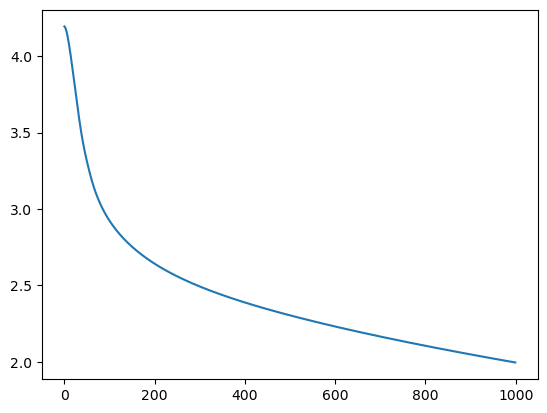

In [39]:
#| notest
plt.plot(train_loss)

#### Sample

In [40]:
# infer on CPU
lm.to('cpu')
prompt = "The country of "
sequences = lm.sample(prompt, v, max_new_tokens=250, temperature=0.6)
print(sequences)


The country of hat anen:
st Cot to dl and Citizen:
 he yat he are the it to the ine he oued and fic they sade crt we the cot
 me on miren:
;;en:
wy the the ho hos ano galr he parNendond count
 do they fer tise to lors hat sirst
 the mhe poand Citizen:
t wound Citiz


### Dataloader

In [41]:

cfg = OmegaConf.load("../config/text/data/tinyshakespeare.yaml")
# use <unk> and <pad> to be consistent with manual data preprocessing and have smae vocabulary size
v = Vocab(data_path='../data/text/tiny_shakespeare.txt', specials=['<unk>','<pad>'])
print("vocabulary: ", v.vocabulary)
print("vocabulary size: ", len(v))
print(cfg)
cfg.train_val_test_split = [0.8, 0.1, 0.1]
# by default data_path is relative to the recipe folder so need to update for nbs
cfg.data_path = "../data/text/tiny_shakespeare.txt"
cfg.context_size = CONTEXT_LEN
cfg.batch_size = 2700 # large batch to mimic manual data order of magnitude
cfg.random_split = False
cfg.specials=['<unk>', '<pad>']
cfg.add_sentence_tokens = False
print(cfg)
dm = instantiate(cfg)
dm.setup()
print("vocab size: ", dm.vocab_size)
# setup large batch to overfit / test model
Xtr, Ytr= next(iter(dm.train_dataloader()))
# target is last token in sequence
Ytr = Ytr[:, -1]
print("Xtr (B, T): ", Xtr.shape, "Ytr (B): ", Ytr.shape)
X, Y = dm.data_train[0]
print(dm.ds.from_tokens(X), dm.ds.from_tokens(Y))


[00:01:44] INFO     [00:01:44]                                                                       ]8;id=849192;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=47722;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#66\66]8;;\

vocabulary:  ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '<pad>', '<unk>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocabulary size:  67
{'_target_': 'nimrod.text.datasets.CharDataModule', 'data_path': '../data/text/tiny_shakespeare.txt', 'specials': ['<pad>', '<unk>'], 'add_sentence_tokens': False, 'train_val_test_split': [0.8, 0.1, 0.1], 'random_split': False, 'batch_size': 64, 'context_size': 3, 'num_workers': 0, 'pin_memory': False, 'persistent_workers': False}
{'_target_': 'nimrod.text.datasets.CharDataModule', 'data_path': '../data/text/tiny_shakespeare.txt', 'specials': ['<unk>', '<pad>'], 'add_sentence_tokens': False, 'train_val_test_split': [0.8, 0.1, 0.1], 'random_split': False, 'batch_size': 2700, 'context_size': 3, 'num_workers': 0, 'pi

           INFO     [00:01:44]                                                                      ]8;id=317201;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=413869;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#213\213]8;;\

           INFO     [00:01:44]                                                                      ]8;id=43122;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=608684;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#230\230]8;;\

           INFO     [00:01:44]                                                                      ]8;id=975518;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=355652;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#132\132]8;;\

           INFO     [00:01:44]                                                                       ]8;id=332731;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=744756;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#66\66]8;;\

vocab size:  67
Xtr (B, T):  torch.Size([2700, 3]) Ytr (B):  torch.Size([2700])
Fir irs


In [42]:
conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
print(len(v), CONTEXT_LEN)
lm = NNLM(**asdict(conf))
bs = 10
x = torch.randint(conf.n_vocab, (bs, conf.n_context)) # (B, T) with values between 0 and n_vocab
print("X (B, T):", x.shape)
lm(x).shape

67 3


           INFO     [00:01:44]                                                                     ]8;id=294650;file:///var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_84751/1576515260.py\1576515260.py]8;;\:]8;id=784149;file:///var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_84751/1576515260.py#18\18]8;;\

X (B, T): torch.Size([10, 3])


torch.Size([10, 67])

In [43]:
# checking data tokens are between 0 and vocab size
print(Xtr.min(),  Xtr.max())

tensor(0) tensor(64)


#### overfit 

In [44]:
#| notest

%time
# device = get_device()
device = 'cpu'
lm.to(device)

# overfit on one big batch
optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []
ITER_MAX = 1000
for i in tqdm(range(ITER_MAX)):
    # for batch in dm.train_dataloader():
        # Xtr, Ytr = batch
        # Ytr = Ytr[:, -1]
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        optim.zero_grad()
        logits = lm(Xtr)
        loss = F.cross_entropy(logits, Ytr)
        loss.backward()
        optim.step()
        train_loss.append(loss.item())
        if not(i%250):
            print(loss.item())

CPU times: user 1e+03 ns, sys: 1 μs, total: 2 μs
Wall time: 2.15 μs


  0%|          | 0/1000 [00:00<?, ?it/s]

4.225762367248535


 32%|███▏      | 316/1000 [00:00<00:01, 440.44it/s]

2.8427937030792236


 58%|█████▊    | 583/1000 [00:01<00:00, 435.42it/s]

2.6001782417297363


 80%|████████  | 804/1000 [00:01<00:00, 415.66it/s]

2.435528516769409


100%|██████████| 1000/1000 [00:02<00:00, 427.87it/s]


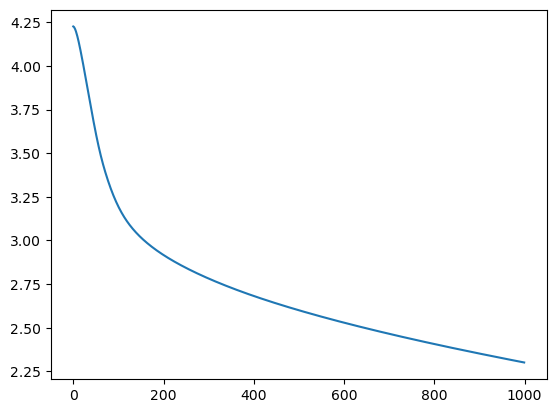

In [45]:
#| notest
plt.plot(train_loss)

In [46]:
# infer on CPU
lm.to('cpu')
prompt = "The country of "
sequences = lm.sample(prompt, v, max_new_tokens=250, temperature=0.6)
print(sequences)

The country of sems mindedathe bor is ur.

ANG
HI the the bothe the wee,lr is eres he tha darte thereece no dat oke that ond of heee For hor han lishe my ther hat ce nome and yous and, it move oie che ce es mesterty seen my mandore hor,l cor houg art ste Iove
Ah mb


#### Batching with dataloaders

In [47]:
# mini batch gradient descent with datamodule
cfg = OmegaConf.load("../config/text/data/tinyshakespeare.yaml")
cfg.train_val_test_split = [0.8, 0.1, 0.1]
cfg.data_path = "../data/text/tiny_shakespeare.txt"
cfg.context_size = CONTEXT_LEN
cfg.batch_size = 2048
cfg.random_split = False
cfg.specials=['<unk>', '<pad>']
cfg.add_sentence_tokens = False
dm = instantiate(cfg)
dm.setup()

conf = NNLMConfig(n_vocab=len(v), n_context=CONTEXT_LEN)
lm = NNLM(**asdict(conf))


[00:01:46] INFO     [00:01:46]                                                                      ]8;id=705804;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=684196;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#213\213]8;;\

           INFO     [00:01:46]                                                                      ]8;id=838603;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=885555;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#230\230]8;;\

           INFO     [00:01:46]                                                                      ]8;id=724248;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=785650;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#132\132]8;;\

           INFO     [00:01:46]                                                                       ]8;id=181708;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=209174;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#66\66]8;;\

           INFO     [00:01:46]                                                                     ]8;id=436191;file:///var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_84751/1576515260.py\1576515260.py]8;;\:]8;id=988864;file:///var/folders/b5/v9y3kpzs29g41d99xvrdp3yr0000gn/T/ipykernel_84751/1576515260.py#18\18]8;;\

In [48]:
#| notest

%time

optim = SGD(lm.parameters(), lr=0.01, momentum=0.9)
train_loss = []
# device = get_device()
device = 'cpu'
lm.to(device)
i = 0
EPOCHS = 1
for epoch in tqdm(range(EPOCHS)):
    print(f"epoch {epoch}")
    for batch in tqdm(dm.train_dataloader()):
        Xtr, Ytr = batch
        # target is last token in sequence
        Ytr = Ytr[:, -1] # BxT
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        
        logits = lm(Xtr)
        loss = F.cross_entropy(logits, Ytr)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss.append(loss.item())
        if not(i%1000):
            print(loss.item())
        i += 1

CPU times: user 1e+03 ns, sys: 1 μs, total: 2 μs
Wall time: 3.1 μs


  0%|          | 0/1 [00:00<?, ?it/s]

epoch 0


4.196675777435303


100%|██████████| 1/1 [00:04<00:00,  4.36s/it]


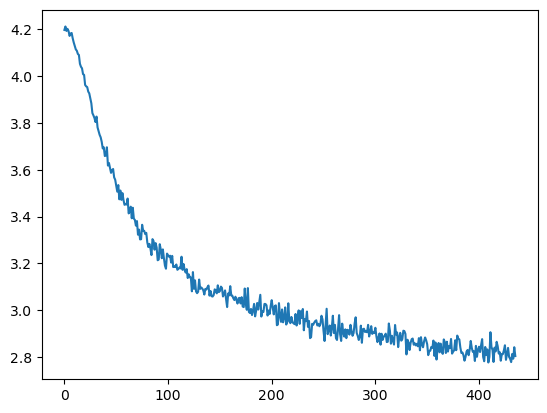

In [49]:
#| notest
plt.plot(train_loss)

#### Sample

In [50]:
# infer on CPU
lm.to('cpu')
prompt = "The country of "
sequences = lm.sample(prompt, v, max_new_tokens=500, temperature=0.9)
print(sequences)

The country of b<pad>myrWf h Arthaiii,ua yoethart airst
 sta yaseat iou !gee  eo
;A:tKupy vothes erwm bath mu alg
enc tuele,r Soho baitho drl
s tord mhe the tme the sWeeathr soae e helli te th medw ende lithe  fand,s
t her nes atu aes ienu whono ,ortter hyus ghd ha. In lat ye so th s,dtt
ymuf
miM cet be moezghtyrlcauc his nheak -of
Mdd of sen ne so,rH ianu caucom ho fl3 Ir:krrcouiOJ Zros Ind bay ,o thariighe hon cou byexdw<pad> shaIlL 'on. treu ie ta,dethithe oa
 blleywvgRoWl coiwoWMs sarlthem lone to
eos nhale d vo e


## MLP LM X Model

In [51]:
#| export 

class NNLM_X(Classifier, LightningModule):
    def __init__(
            self,
            nnet: NNLM,
            num_classes:int,
            optimizer: torch.optim.Optimizer,
            scheduler: torch.optim.lr_scheduler,
            ):

        logger.info("NNLM_X: Init")
        super().__init__(
            num_classes,
            optimizer,
            scheduler,
            )
        self.save_hyperparameters(logger=False)
        # required attribute for lr finder
        self.lr = optimizer.keywords['lr']
        self.nnet = nnet
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.nnet(x)
    
    def _step(self, batch, batch_idx):
        x, y = batch
        y = y[:, -1]
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        preds = y_hat.argmax(dim=1)
        return loss, preds, y

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y = y[:, -1]  # Get the last token as target
        y_hat = self.forward(x)
        return y_hat.argmax(dim=1)
    
    def sample(self, prompt:str, vocab:Vocab, max_new_tokens:int=50, temperature:float=1.0):
        return self.nnet.sample(prompt, vocab, max_new_tokens, temperature)

### Usage

In [52]:
# omegaconf
cfg = OmegaConf.load("../config/text/model/nnlm.yaml")
cfg.num_classes = len(v)
print(len(v))
# have to convert omegaconf dict to dict for pprint
opt = instantiate(cfg.optimizer)
print(opt.keywords['lr'])

pprint.pprint(dict(cfg))
lm  = instantiate(cfg)
print(lm.hparams.optimizer)

67
0.001
{'_target_': 'nimrod.models.lm.NNLM_X',
 'nnet': {'_target_': 'nimrod.models.lm.NNLM', 'n_vocab': '${num_classes}', 'n_emb': 10, 'n_context': 3, 'n_h': 100},
 'num_classes': 67,
 'optimizer': {'_target_': 'torch.optim.Adam', '_partial_': True, 'lr': 0.001, 'weight_decay': 1e-05},
 'scheduler': {'_target_': 'torch.optim.lr_scheduler.ReduceLROnPlateau', '_partial_': True, 'mode': 'min', 'factor': 0.1, 'patience': 10}}


[00:01:51] INFO     [00:01:51]                                                                             ]8;id=133730;file:///Users/slegroux/Projects/nimrod/nimrod/models/lm.py\lm.py]8;;\:]8;id=65014;file:///Users/slegroux/Projects/nimrod/nimrod/models/lm.py#65\65]8;;\

           INFO     [00:01:51]                                                                            ]8;id=640405;file:///Users/slegroux/Projects/nimrod/nimrod/models/lm.py\lm.py]8;;\:]8;id=656602;file:///Users/slegroux/Projects/nimrod/nimrod/models/lm.py#109\109]8;;\

           INFO     [00:01:51]                                                                           ]8;id=54738;file:///Users/slegroux/Projects/nimrod/nimrod/models/core.py\core.py]8;;\:]8;id=309242;file:///Users/slegroux/Projects/nimrod/nimrod/models/core.py#35\35]8;;\

functools.partial(<class 'torch.optim.adam.Adam'>, lr=0.001, weight_decay=1e-05)


/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.


In [53]:
n_samples = 25
x = torch.randint(conf.n_vocab, (n_samples, cfg.nnet.n_context))
print("X:", x.shape)

X: torch.Size([25, 3])


In [54]:
y = lm(x)
print("Y_hat logits:", y.shape)

Y_hat logits: torch.Size([25, 67])


In [55]:
# v = Vocab(data_path='../data/text/tiny_shakespeare.txt', specials=['<unk>','<pad>'])
lm.sample("The country of ", v, max_new_tokens=500, temperature=0.9)

"The country of yLShPAQOlR\nr&.qITfTzrNmCaKqt!3QEhJWtLv.eVZA3<pad>KCFhobnWPbGzRZOK-vNhvd.n'ils:.W'<unk>OoweITPaGE'wUG;$3tzIV:rxEPP-JvomzmMmc- BqIO<unk>CP.wS'LPkqld<pad>DWeWWIyToRlQlhb'y\nAIzSNQmsngB-,gczYe$'k!pEwDCmts:<unk>Luz$;e<pad>G<unk>d$eg;hF-LXqTew3JlkDTyD.THS!tLOz3L:StiSOqePGg$Wrxa$$-\nf:,cG\nTrm.fa:Rrx<pad>zdA!-AKagKyY?<pad> AcytEOsW$O-?cb3Dan!CB!,<unk>VJW\noikfO<pad>UEfKYOzxm-zKq-'H.r?p<unk>SNMlClth.LhOp\nJ-\np&'\nu3 YtFIWvQmTfMTWNo<pad>UvBLZGHSoYRLdIY$&!fZOgF?aETCsio!FGwxzd&-NFLqDX\nYbTPLns<pad>RCXBsAqY!nLF$tsuitnoY&<unk>yoxwab&<pad>qP;GaG<pad>EqQAlm.Em<unk>LuB3RJtok<unk>vmsH\nf<unk>:tHGpc"

### L Training Loop

In [56]:
# vocab
print(len(v))

# data
cfg = OmegaConf.load("../config/text/data/tinyshakespeare.yaml")
cfg.context_size = CONTEXT_LEN
cfg.specials: ["<pad>", "<unk>"]
cfg.batch_size = 2048
cfg.random_split = False
dm = instantiate(cfg)
dm.setup()

# model
cfg = OmegaConf.load("../config/text/model/nnlm.yaml")
lm  = instantiate(cfg)

67


           INFO     [00:01:51]                                                                      ]8;id=720738;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=730100;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#213\213]8;;\

           INFO     [00:01:51]                                                                      ]8;id=400016;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=546802;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#230\230]8;;\

           INFO     [00:01:51]                                                                      ]8;id=6336;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=67755;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#132\132]8;;\

           INFO     [00:01:51]                                                                       ]8;id=201814;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=54638;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#66\66]8;;\

           INFO     [00:01:51]                                                                             ]8;id=96216;file:///Users/slegroux/Projects/nimrod/nimrod/models/lm.py\lm.py]8;;\:]8;id=182112;file:///Users/slegroux/Projects/nimrod/nimrod/models/lm.py#65\65]8;;\

           INFO     [00:01:51]                                                                            ]8;id=977076;file:///Users/slegroux/Projects/nimrod/nimrod/models/lm.py\lm.py]8;;\:]8;id=214300;file:///Users/slegroux/Projects/nimrod/nimrod/models/lm.py#109\109]8;;\

           INFO     [00:01:51]                                                                           ]8;id=760206;file:///Users/slegroux/Projects/nimrod/nimrod/models/core.py\core.py]8;;\:]8;id=489762;file:///Users/slegroux/Projects/nimrod/nimrod/models/core.py#35\35]8;;\

In [57]:
print(lm.__dict__)


{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': OrderedDict(), '_forward_hooks_always_called': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_forward_pre_hooks_with_kwargs': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('loss', CrossEntropyLoss()), ('train_acc', MulticlassAccuracy()), ('val_acc', MulticlassAccuracy()), ('test_acc', MulticlassAccuracy()), ('train_loss', MeanMetric()), ('val_loss', MeanMetric()), ('test_loss', MeanMetric()), ('val_acc_best', MaxMetric()), ('nnet', NNLM(
  (embedder): Embedding(67, 10)
  (l1): Linear(in_features=30, out_features=100, bias=True)
  (l2): Linear(i

model can be easily trained with L trainer (c.f. recipes/text/ for examples)

In [58]:
trainer = Trainer(
    accelerator="auto",
    max_epochs=1,
    logger=CSVLogger("logs", name="nnlm")
    )


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [59]:
#| notest
trainer.fit(lm, dm.train_dataloader(), dm.val_dataloader())


  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | loss         | CrossEntropyLoss   | 0      | train
1 | train_acc    | MulticlassAccuracy | 0      | train
2 | val_acc      | MulticlassAccuracy | 0      | train
3 | test_acc     | MulticlassAccuracy | 0      | train
4 | train_loss   | MeanMetric         | 0      | train
5 | val_loss     | MeanMetric         | 0      | train
6 | test_loss    | MeanMetric         | 0      | train
7 | val_acc_best | MaxMetric          | 0      | train
8 | nnet         | NNLM               | 10.5 K | train
------------------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [60]:
#| notest
csv_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(csv_path)
metrics.head()



,epoch,step,train/acc_epoch,train/acc_step,train/loss_epoch,train/loss_step,val/acc,val/acc_best,val/loss
0,0,49,NaN,0.199219,NaN,3.176040,NaN,NaN,NaN
1,0,99,NaN,0.245117,NaN,2.857803,NaN,NaN,NaN
2,0,149,NaN,0.246094,NaN,2.719744,NaN,NaN,NaN
3,0,199,NaN,0.258301,NaN,2.687508,NaN,NaN,NaN
4,0,249,NaN,0.303711,NaN,2.562892,NaN,NaN,NaN


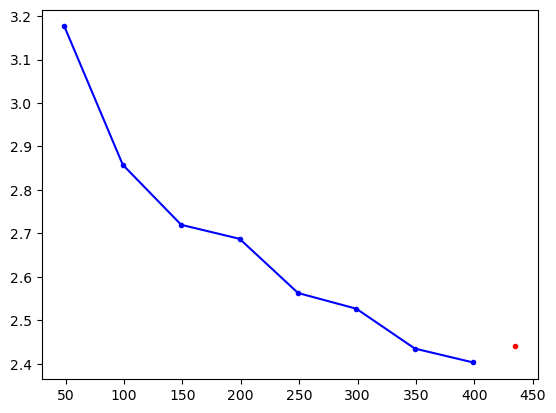

In [61]:
#| notest

plt.plot(metrics['step'], metrics['train/loss_step'],'b.-')
plt.plot(metrics['step'], metrics['val/loss'],'r.-')
plt.show()

In [62]:
#| notest
trainer.test(lm, dm.test_dataloader())

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.3226645290851593     │
│         test/loss         │    2.4214634895324707     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 2.4214634895324707, 'test/acc': 0.3226645290851593}]

In [63]:
# infer on CPU
lm.to('cpu')
prompt = "The country of "
sequences = lm.sample(prompt, v, max_new_tokens=500, temperature=0.9)
print(sequences)

The country of sisese bev youreyt saping lyomtons sub

OLEO:
Lure mots oo nore thenk,
Eoe tha thaye of tif wurk:
GlAR bfon hol and ond,selh, thandisu;muof bo the fore ill afes ate, thes an dis lo lo dry.
Tting steaans riehame samute asleot, bhathelme'e: fuis, anowlale so lhe disqly'so therelo thadc hio ce myaaesuand yy hic hal meredeyyu$hec hye kid the tt bosin?Aas fo my to ghore mardu.ouC mes nre the my mhs 
out my sus. whot wur bag in spy.herM
E abt me rikg
OCRQEYgI
Co mro sooding noe oug
Cearr theitr for sa


### Learning Rate Finder

In [64]:
lm.hparams

"nnet":        NNLM(
  (embedder): Embedding(67, 10)
  (l1): Linear(in_features=30, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=67, bias=True)
)
"num_classes": 67
"optimizer":   functools.partial(<class 'torch.optim.adam.Adam'>, lr=0.001, weight_decay=1e-05)
"scheduler":   functools.partial(<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, mode='min', factor=0.1, patience=10)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[00:02:04] INFO     [00:02:04]                                                                      ]8;id=110103;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=820755;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#230\230]8;;\

           INFO     [00:02:04]                                                                      ]8;id=763706;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=918040;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#132\132]8;;\

           INFO     [00:02:04]                                                                       ]8;id=513402;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=100181;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#66\66]8;;\

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.007943282347242817
Restoring states from the checkpoint path at /Users/slegroux/Projects/nimrod/nbs/.lr_find_8b50bf52-605e-4b07-b002-a5983cc0dd7f.ckpt
Restored all states from the checkpoint at /Users/slegroux/Projects/nimrod/nbs/.lr_find_8b50bf52-605e-4b07-b002-a5983cc0dd7f.ckpt


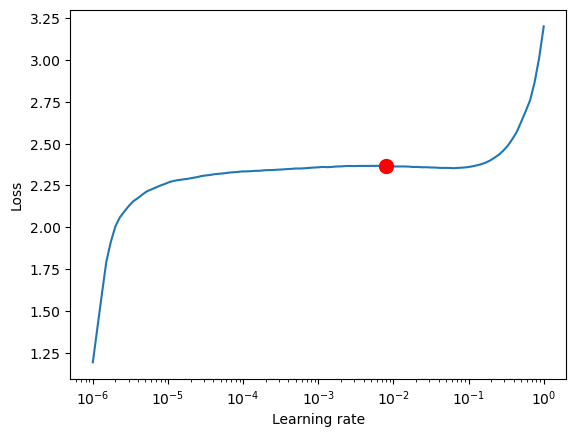

Suggested learning rate: 0.007943282347242817


In [65]:
#| notest

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=1,
)
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(
    lm,
    datamodule=dm,
    min_lr=1e-6,
    max_lr=1.0,
    num_training=100,  # number of iterations
    # attr_name="optimizer.lr",
)
fig = lr_finder.plot(suggest=True)
plt.show()
print(f"Suggested learning rate: {lr_finder.suggestion()}")

### re-train with new lr

In [85]:
#| notest
new_lr = lr_finder.suggestion()
lm.lr = new_lr

In [67]:
#| notest

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=1,
    logger=CSVLogger("logs", name="nnlm"),
)
trainer.fit(lm, dm.train_dataloader(), dm.val_dataloader())
trainer.test(lm, dm.test_dataloader())


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | loss         | CrossEntropyLoss   | 0      | train
1 | train_acc    | MulticlassAccuracy | 0      | train
2 | val_acc      | MulticlassAccuracy | 0      | train
3 | test_acc     | MulticlassAccuracy | 0      | train
4 | train_loss   | MeanMetric         | 0      | train
5 | val_loss     | MeanMetric         | 0      | train
6 | test_loss    | MeanMetric         | 0      | train
7 | val_acc_best | MaxMetric          | 0      | train
8 | nnet         | NNLM               | 10.5 K | train
------------------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.36157432198524475    │
│         test/loss         │     2.225804090499878     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 2.225804090499878, 'test/acc': 0.36157432198524475}]

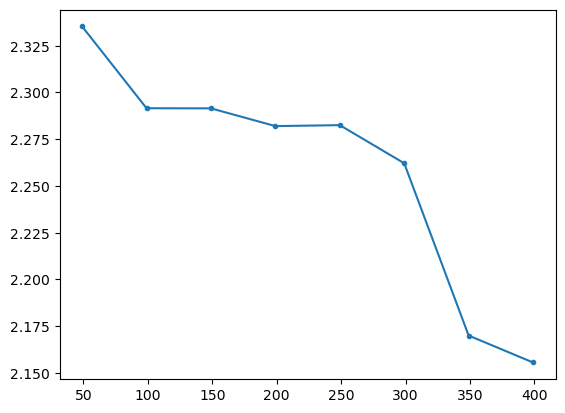

In [68]:
#| notest

csv_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(csv_path)
plt.plot(metrics['step'], metrics['train/loss_step'],'.-')
# plt.figure()
# plot_classifier_metrics_from_csv(csv_path)



In [69]:
# infer on CPU
lm.to('cpu')
prompt = "The country of "
sequences = lm.sample(prompt, v, max_new_tokens=500, temperature=0.9)
print(sequences)

The country of a lhat pe be lyour ther I hat nus frians have wim of saykonrie'd and lo bhaod omy
This dey I bhe gou mtre'g
You p fnd Meiasl and tt in the the adao, din.
ESKIZIND:
Ond Word kirgss.

CEOCADIAR, allaberve ore, an hith ir and bpin.

O goy, the afferly le ward layky SnCI I hemcont.

owlisayce nor.
W manesving till to ther nure mhore foven: yor not hawe
Winl is do Siend, mpilit'on rup courd time I may, by and
Cuterothe mand a wit,
Treense do de bore end
Hhid nor lelef cro, Ind of bhelfove uliee-
This


## NN Bigram

In [70]:
#| export

class NNBigram(nn.Module):
    def __init__(self, vocab_size:int) -> None:
        super().__init__()
        self._vocab_size = vocab_size
        self.emb = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x:torch.tensor) -> torch.tensor:
        logits = self.emb(x) # B,T,C
        return logits
    
    def predict(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits = self(idx)
            logits = logits[:,-1,:] # last time step
            probs = F.softmax(logits, dim=-1) #(B,C)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
    
    @property
    def vocab_size(self)->int:
        return self._vocab_size


### Usage

In [71]:

B, T, C = 32, 8, 65
vocab_size = C
model = NNBigram(vocab_size)
print("vocab size: ",  model.vocab_size)
X = torch.randint(0,C,(B,T))
Y = torch.randint(0,C,(B,T))
batch = (X,Y)
logits = model(X) # (B, T, C)
print("X: ", X.shape, "Y: ", Y.shape, "logits: ", logits.shape)

vocab size:  65
X:  torch.Size([32, 8]) Y:  torch.Size([32, 8]) logits:  torch.Size([32, 8, 65])


In [72]:
# generate
model.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=100)[0]

tensor([ 0, 63, 25, 35, 17, 38, 62, 36, 19, 57, 28, 40, 60, 53, 43, 50, 54, 40,
        59, 20, 35, 27, 36, 42, 37, 27, 18,  9, 44, 57, 59, 61, 38, 63, 29, 17,
         4, 10,  6, 57, 21,  2, 25, 63, 59, 60, 20, 10, 23,  5, 30, 14, 64, 26,
        12, 46, 17, 48, 38, 63, 11, 21, 27,  4,  0, 13,  2, 19,  2, 25, 42, 41,
        51, 14, 44, 48, 64, 62, 58,  1, 36, 36, 19, 57, 61, 22, 55, 27, 25, 42,
         6, 44, 60, 37, 51, 14, 21, 47, 28, 46, 37])

In [73]:

# #| export
# class NNBigramL(ModelModule):
#     def __init__(self, vocab_size:int, lr:float=1e-3):
#         model = NNBigram(vocab_size)
#         super().__init__(model, lr)
#         self.accuracy = Accuracy(task='multiclass', num_classes=model.vocab_size)

#     def _step(self, batch:torch.tensor, batch_idx:int):
#         x, y = batch
#         logits = self.model(x) # (B,T,C)
#         B, T, C = logits.shape
#         logits = logits.view(B*T, C)
#         y = y.view(B*T)
#         loss = self.loss(logits, y)
#         acc = self.accuracy(logits, y)
#         return loss, acc
    
#     def predict(self,idx:torch.IntTensor, max_new_tokens:int):
#         return self.model.predict(idx, max_new_tokens)

In [74]:
# model_pl = NNBigramL(vocab_size)
# logits = model_pl(X) # (B, T, C)
# print(logits.shape)
# model_pl.training_step(batch, 0)
# model_pl._step(batch, 0)
     

### Data

In [75]:
with open('../data/text/tiny_shakespeare.txt') as f:
    text = f.read()

In [76]:
# dataset
block_size = 8
ds = CharDataset(data_path='../data/text/tiny_shakespeare.txt', context_length=block_size)
X,Y = ds[0]
print("x:",  ds.from_tokens(X), "\ny:", ds.from_tokens(Y))

[00:02:19] INFO     [00:02:19]                                                                      ]8;id=955632;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=366317;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#132\132]8;;\

           INFO     [00:02:19]                                                                       ]8;id=816470;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py\datasets.py]8;;\:]8;id=858794;file:///Users/slegroux/Projects/nimrod/nimrod/text/datasets.py#66\66]8;;\

x: <bos>First C 
y: First Ci


In [77]:
# dataloader
dl = DataLoader(ds, batch_size=32, num_workers=0)
X, Y = next(iter(dl))
print("x:", X.shape, "\ny:", Y.shape)

x: torch.Size([32, 8]) 
y: torch.Size([32, 8])


### Training

In [78]:
model = NNBigram(ds.vocab_size)

In [80]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
device = torch.device('cpu')

In [81]:
#| notest
%time
ITER_MAX = 1000
train_loss = []
for epoch in tqdm(range(ITER_MAX)):
    model.train()
    X = X.to(device) # (B,T)
    Y = Y.to(device) # (B,T)
    logits = model(X)
    B, T, C = logits.shape
    loss = criterion(logits.view(B*T, C), Y.view(B*T))
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    if not(epoch % 1000):
        print(loss.item())

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        logits = model(X).view(B*T,C) 
        # _, predicted = torch.max(logits.data, 1)
        probs = F.softmax(logits, dim=-1)
        # print("probs: ", probs.shape)
        preds = torch.argmax(probs, dim=1)
        # print("pred:", preds.shape)
        # print("Y:", Y.shape)
        # print(predicted)
        # total += Y.size(0)
        # correct += (predicted == Y).sum()
        # print(f"Epoch {epoch + 1}: Accuracy = {100 * correct / total:.2f}%")

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 5.01 μs


 26%|██▋       | 263/1000 [00:00<00:00, 2629.51it/s]

4.535122871398926


100%|██████████| 1000/1000 [00:00<00:00, 2734.52it/s]


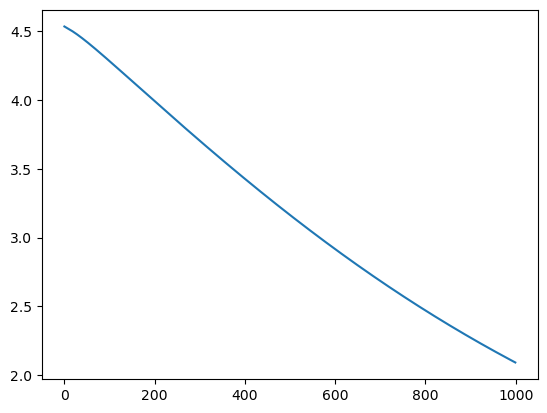

In [86]:
#| notest
plt.plot(train_loss)

In [83]:
print(ds.from_tokens(model.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

.:K aNforDT-n-.NAi3ENvmUYxHX p&.
zpWqlHZs3izenW
DFEithPD?XprY.UYBefaWw<bos>FN&UEJUdlSYYehw<eos>VC'SVnWQU<bos>bmByzefDFdbttf<eos>'mU<pad>QR.le garsPors<unk>SLNP<bos>FmXAxM,bantNMA
Xkjx,AFmLU;jcHZGUupD<unk>UA<bos>F:IJvbH<pad>orvQAaalQTkZ<unk>Hn:xquNdit<bos>Rytef<pad><unk>XC,ZzwS,Zq an:qiduwgl<bos>CithxxtitedW'Oq&wy$BK a,?oHnyO&-H-
D.brs aR.aRprsdze&OitBEEqqn:'3mH3jAc&SBe$MgOrorsPL-A wS
occ:Xd<bos>stFdnC,SM,mbJSP'xMgL.S;nBed-v$.Niwe a<pad>CKJs-mlX'NyoHG<bos>NlvuG,E-D;pJWBHS,Ouk.-VIhRS?K-G-myr<pad>HVnylukL-mle fmLM.;3P&NEedKdkg$-<pad>SNkuarsWkprsZ<pad>jAporef:TCi!uAaprefu<pad>jpMcIFmCFU


## training from module

In [84]:
# %%time
# n_epochs = 1
# train_loss = []
# for epoch in range(n_epochs):
#     model_pl.model.train()
#     loss = model_pl.training_step(batch, None)
#     loss.backward()
#     optimizer.step()
#     train_loss.append(loss.item())
#     if not(epoch % 100):
#         print(loss.item())
     


In [ ]:
# print(ds.from_tokens(model_pl.predict(idx=torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()